#  분석 배경 

#### 00 공장의 고객사에서 최근 들어 "Scale 불량 발생 증가"라는 이슈가 발생했다. 그 원인을 분석해 본 결과 압연공정에사 Scale 불량이 급증한 것을 확인할 수 있었다. 그래서 데이터를 수집하여 다양한 분석을 통해 불량 발생의 근본 원인을 찾고 결과를 해석하여 개선 기회를 도출한다. 

In [1]:
#### 왜 이모델을 적용하는지 / 선형회귀는 선형성을 보일 때 적용한다. 
#### 선형회귀의 사전조건이 만족한는지??? >> DT 쓰기 비선형적 모델이니깐 불량률 32% 
#### 두께가 영향을 주지만 우리가 관리할 팩터가 아니다. 
#### 반드시 모든 데이터를 분석할 필요가 없고 개선방안을 제시할 수 있으면 된다. 
#### HSB는 적용하지 않았을 때 반드시 불량이 된다. 
#### 그래프, 변수선택법- DT-카이제곱, 회귀분석 랜텀 포레스트로 vital few  >> 분류 모델을 만든다. 모델을 평가한다. 
#### 예측 시뮬레이션 및 예측 결과 확인 score 함수를 통한 점수 제공 
#### scatter plot에는 색깔을 넣어서 그려본다. 

# 0. 패키지 불러오기 

In [2]:
#데이터 구성: Series,DataFrame
import pandas as pd

#행렬 연산
import numpy as np

#데이터 시각
import matplotlib.pyplot as plt
import seaborn as sns

#회귀분석
from statsmodels.formula.api import ols

#qqplot,회귀분석의 상수항 추가 
from statsmodels.api import qqplot, add_constant

#선형 모델 formula 
import statsmodels.formula.api as sm

#평가함수
from statsmodels.tools.eval_measures import rmse 

#jupyter notebook 사용시 그래프 자동 출력 옵션 
%matplotlib inline

#다중공선성 확인 
from statsmodels.stats.outliers_influence import variance_inflation_factor

#날짜 데이터 생성
from datetime import datetime

#자기 상관 함수, 부분 자기 상관 함수 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# ARIMA
from statsmodels.tsa.arima_model import ARIMA

#선형회귀모형
from sklearn.linear_model import LinearRegression 

#변수 선택법(후진제거법)
from sklearn.feature_selection import RFE

#Scale 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler 

# 데이터 분할:train,test
from sklearn.model_selection import train_test_split

# 로지스틱 회귀
from statsmodels.api import Logit

# export_graphviz : 나무 구조 생성 및 저장 
from sklearn.tree import export_graphviz

# graphviz : 나무 구조 시각화 (dot.확자아 파일 불러오기 등)
import graphviz

# 분류 Decision Tree
from sklearn.tree import DecisionTreeClassifier 

# 분류 Random Forest 
from sklearn.ensemble import RandomForestClassifier 

# 분류 Gradient Boosting  
from sklearn.ensemble import GradientBoostingClassifier

# 최적 모델, 파라미터 탐색 
from sklearn.model_selection import GridSearchCV

# 평가함수
from sklearn.metrics import accuracy_score

# confusion matrix
from sklearn.metrics import confusion_matrix

pd.options.display.precision=3

#한글깨짐 방지
import matplotlib.font_manager as fm 
font_list=[font.name for font in fm.fontManager.ttflist]
font_list
plt.rcParams['font.family']='NanumBarunGothic'

# 1. 데이터 불러오기 

### 1-1 데이터 구성하기 

In [3]:
df_raw=pd.read_csv("/home/piai/바탕화면/강연주/과제/3/SCALE불량.csv", engine='python', encoding='EUC-KR')
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


In [4]:
df_raw.describe().round(3)

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
count,720.000,720.000,720.000,720.000,720.000,720.000,720.000,720.000,720.000,720.000,720.000,720.000,720.000
mean,29.268,2807.128,34323.269,41481.778,1.497,1155.339,88.528,1149.667,78.803,300.564,1149.667,933.921,8.319
std,19.153,517.840,13828.435,24751.322,0.500,20.866,37.661,17.572,36.421,45.390,17.572,107.864,1.623
min,12.030,1800.000,7893.000,7820.000,1.000,1103.000,43.000,1113.000,35.000,221.000,1113.000,0.000,5.000
25%,16.090,2466.000,22663.000,17757.500,1.000,1139.000,65.000,1132.000,57.750,257.000,1132.000,889.750,6.000
50%,20.130,2725.000,37380.000,36120.000,1.000,1158.000,75.000,1155.000,67.500,304.000,1155.000,951.000,8.000
75%,40.000,3125.000,43735.000,61120.000,2.000,1171.000,101.000,1164.000,86.000,342.000,1164.000,994.250,10.000
max,100.340,4575.000,54917.000,115080.000,2.000,1206.000,312.000,1185.000,294.000,398.000,1185.000,1078.000,10.000


### 1-2 변수 탐색 

#### PLATE_NO : plate number : ID의 역할 

#### * 목표 변수 
#### SCALE : Scale 불량 여부 

#### * 설명 변수  

#### - 판 특성 
#### 1) 화학적 특성 
#### STEEL_KIND : 강종  
#### 2) 물리적 특성 (고객의 주문으로 변경하기 어려운 사항이다.) 
#### PT_THK : plate의 두께               
#### PT_WDTH : plate의 폭                 
#### PT_LTH : plate의 길이                
#### PT_WGT : plate의 중량 
 
#### - 가열로 특성 
#### FUR_NO : 가열로 호기               
#### FUR_NO_ROW : 가열로 작업 순번             
#### FUR_HZ_TEMP : 가열로 가열대 온도           
#### FUR_HZ_TIME : 가열로 가열대 시간             
#### FUR_SZ_TEMP : 가열로 균열대 온도             
#### FUR_SZ_TIME : 가열로 균열대 시간            
#### FUR_TIME : 가열로 시간                
#### FUR_EXTEMP : 추출 온도 

#### - 압연 특성 
#### ROLLING_TEMP_T5 : 압연 온도       
#### HSB : Hot_Scale_Breaker : 강편의 표면에 산화작용으로 생긴 스케일을 제거하는 기구                 
#### ROLLING_DESCALING : 압연 중 descaling 횟수 

#### - 기타 특성 
#### ROLLING_DATE : 작업시각
#### SPEC : 제품 규격  
#### WORK_GR : 작업조              

### 1-3 데이터 전처리 

In [5]:
# 결측 처리 
df_raw.isnull().sum(axis=0)

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

In [6]:
# 변수별 타입 분석 
df_raw.dtypes

PLATE_NO              object
ROLLING_DATE          object
SCALE                 object
SPEC                  object
STEEL_KIND            object
PT_THK               float64
PT_WDTH                int64
PT_LTH                 int64
PT_WGT                 int64
FUR_NO                object
FUR_NO_ROW             int64
FUR_HZ_TEMP            int64
FUR_HZ_TIME            int64
FUR_SZ_TEMP            int64
FUR_SZ_TIME            int64
FUR_TIME               int64
FUR_EXTEMP             int64
ROLLING_TEMP_T5        int64
HSB                   object
ROLLING_DESCALING      int64
WORK_GR               object
dtype: object

In [7]:
# scale 양품은 0, 불량은 1로 바꾸기 
df_raw['SCALE'] = df_raw['SCALE'].map(lambda x : 0 if x == "양품" else 1)

In [8]:
df_raw.dtypes

PLATE_NO              object
ROLLING_DATE          object
SCALE                  int64
SPEC                  object
STEEL_KIND            object
PT_THK               float64
PT_WDTH                int64
PT_LTH                 int64
PT_WGT                 int64
FUR_NO                object
FUR_NO_ROW             int64
FUR_HZ_TEMP            int64
FUR_HZ_TIME            int64
FUR_SZ_TEMP            int64
FUR_SZ_TIME            int64
FUR_TIME               int64
FUR_EXTEMP             int64
ROLLING_TEMP_T5        int64
HSB                   object
ROLLING_DESCALING      int64
WORK_GR               object
dtype: object

In [9]:
# 불필요 변수 제거 
df_raw.drop(["PLATE_NO","SPEC","FUR_EXTEMP","ROLLING_DATE"],axis=1, inplace=True)

In [10]:
# 연속형 변수, 범주형 변수 구분 
df_raw_numeric=df_raw.select_dtypes(exclude='object')
df_raw_object=df_raw.select_dtypes(include='object')

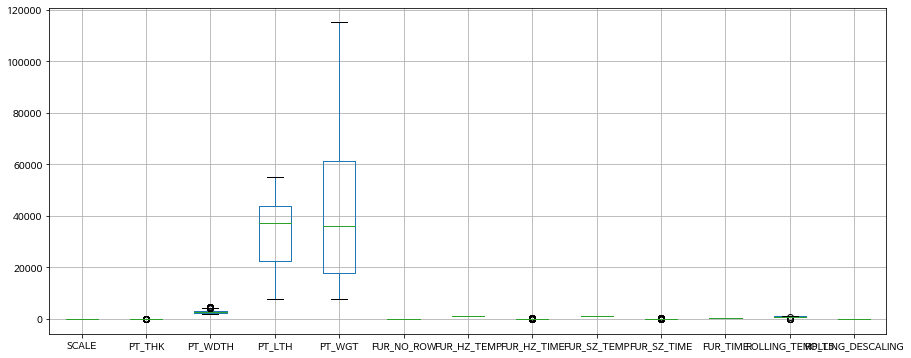

In [11]:
# 이상치 제거 
df_raw_numeric.boxplot(figsize=(15,6))

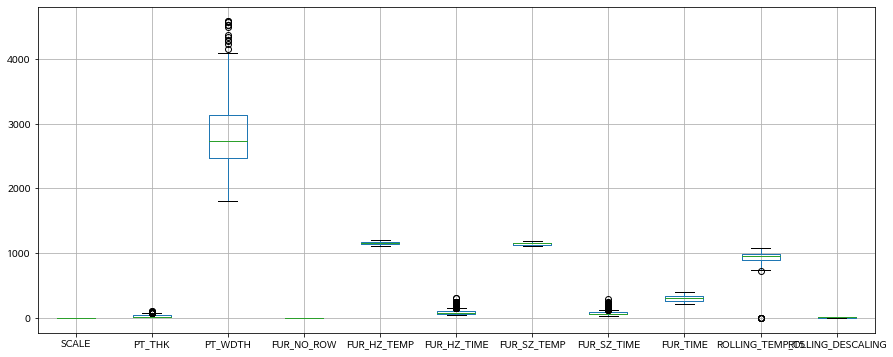

In [12]:
# 변수별 범위의 차이로 인해 이상치 재확인 
df_raw_numeric_1=df_raw_numeric.drop(["PT_LTH","PT_WGT"], axis=1)
df_raw_numeric_1.boxplot(figsize=(15,6))

#### ROLLING_TEMP_T5"에서 이상치가 확인되었다. 

In [13]:
# 이상치 제거 
df_raw.sort_values(by=["ROLLING_TEMP_T5"], axis=0, ascending=True)[0:20]

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
496,0,T0,40.35,2497,23592,37320,3호기,1,1119,109,1117,76,383,0,적용,6,3조
495,0,T5,80.82,2085,13176,17430,1호기,2,1130,92,1124,61,362,0,적용,6,3조
494,0,T5,80.82,2085,12919,17090,2호기,1,1133,89,1122,59,378,0,적용,6,2조
184,0,C0,16.09,2221,43596,61150,3호기,1,1169,64,1164,61,308,0,적용,10,3조
185,0,C0,16.09,2221,43596,61150,3호기,2,1163,57,1166,67,303,0,적용,10,4조
41,0,T8,55.51,3765,11398,37400,3호기,2,1132,95,1128,80,341,0,적용,6,1조
519,0,C0,13.06,3445,53682,18960,2호기,2,1147,73,1129,164,342,723,적용,10,3조
448,0,T7,40.35,2511,22669,36060,1호기,1,1178,90,1127,138,333,745,적용,6,3조
77,0,T8,75.71,2725,9749,15790,3호기,2,1123,79,1126,61,291,760,적용,6,1조
74,0,T8,73.71,2725,9754,15380,2호기,2,1113,96,1122,68,310,773,적용,6,3조


In [14]:
df_raw.drop(df_raw.loc[df_raw["ROLLING_TEMP_T5"]==0].index, inplace=True)
df_raw.sort_values(by=["ROLLING_TEMP_T5"], axis=0, ascending=True)[0:5]

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
519,0,C0,13.06,3445,53682,18960,2호기,2,1147,73,1129,164,342,723,적용,10,3조
448,0,T7,40.35,2511,22669,36060,1호기,1,1178,90,1127,138,333,745,적용,6,3조
77,0,T8,75.71,2725,9749,15790,3호기,2,1123,79,1126,61,291,760,적용,6,1조
74,0,T8,73.71,2725,9754,15380,2호기,2,1113,96,1122,68,310,773,적용,6,3조
431,0,T7,40.35,2481,22663,35620,2호기,1,1162,85,1126,93,278,802,적용,6,1조


#### 압연 온도가 0인 이상치를 제거했다. 

# 2. 탐색적 분석

### 2-1 Plate의 특성에 따른 양품/불량 경향성 

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


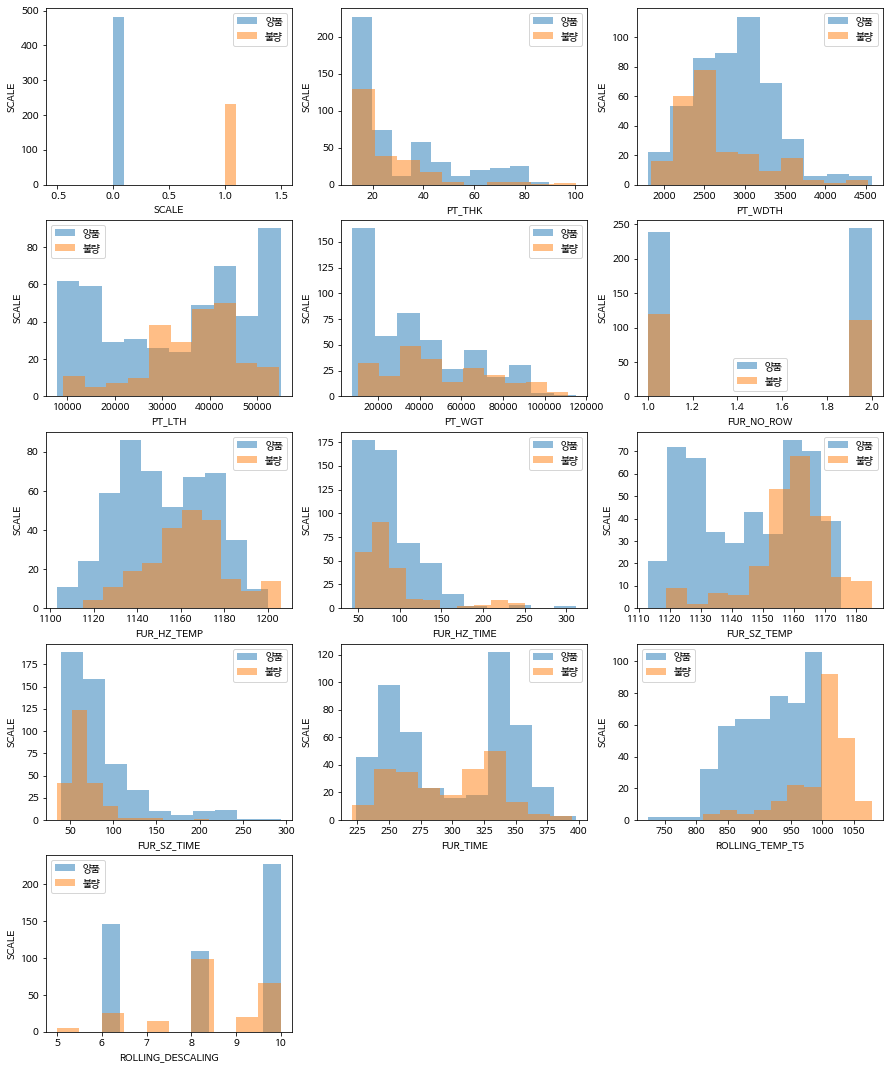

In [15]:
i = 0
fig = plt.figure(figsize = (15, 50))
columns = df_raw_numeric.columns
columns
for col in columns:
    plt.subplot(df_raw_numeric.shape[1], 3, i+1)
    i += 1
    plt.hist(df_raw[df_raw["SCALE"] == 0][col], label = "양품", alpha = 0.5)
    plt.hist(df_raw[df_raw["SCALE"] == 1][col], label = "불량", alpha = 0.5)
    plt.xlabel(col)
    plt.ylabel("SCALE")
    plt.legend()
plt.show()

#### 가열로 가열대 온도는 1150도 이상에서 불량률이 급격하게 증가하였다. 
#### 가열로 균열대 온도는 1145도 이상에서 불량률이 급격하게 증가하였다. 
#### 압연온도 1000도 이상에서는 불량률이 100%이다. 

### 2-2 Plate의 특성에 따른 양품/불량 비율

In [16]:
# SCALE을 목표변수로 하는 히스토그램 
def fun_plot_hist(data,var): 
    plt.hist(data[data["SCALE"]==0][var],label="양품", bins=10, alpha=0.5)
    plt.hist(data[data["SCALE"]==1][var],label="불량", bins=10, alpha=0.5)
    plt.legend()

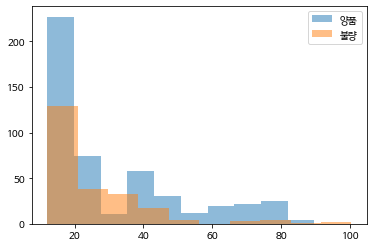

In [17]:
# plate 두께에 따른 양품/불량 수
fun_plot_hist(df_raw,"PT_THK")  

#### 표본의 대부분은 두께 60 미만에 밀집되어 있다. 
#### plate의 두께가 약 48미만에서는 불량률이 30%이상인 것을 확인할 수 있다. 반면, plate의 두께 약 48 초과에서는 불량률이 30%미만으로 현저히 감소한다. 이에 따라 두께가 두꺼워 질수록 불량률이 낮아지는 것을 확인할 수 있다.
#### 또한, 두께가 90 초과에서는 불량률이 100%라는 결과를 확인할 수 있다. 

#### >> plate의 두께가 50~80일 때 불량률이 낮다는 결론을 도출할 수 있다.

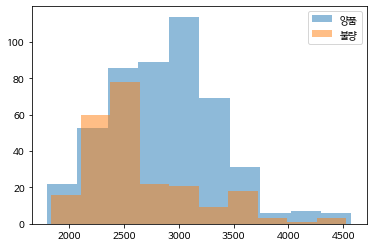

In [18]:
# plate 폭에 따른 양품/불량 수 
fun_plot_hist(df_raw,"PT_WDTH")

#### 두께 2600 미만에서는 높은 불량률을 보이지만 2600~3450까지는 낮은 불량률을 보인다. 
#### >> plate의 두께가 2600~3450일 때 불량률이 낮다는 결론을 도출할 수 있다. 

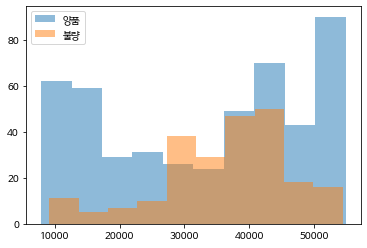

In [19]:
# plate 길이에 따른 양품/불량 수
fun_plot_hist(df_raw,"PT_LTH")

#### plate 길이의 경우 약 2800이하에서, 4500이상에서 낮은 불량률을 보인다. 
#### >> 뷸량률을 낮추기 위해서는 plate의 길이를 2800 이하로 하거나 4500이상으로 해야 한다는 결론을 도출할 수 있다. 

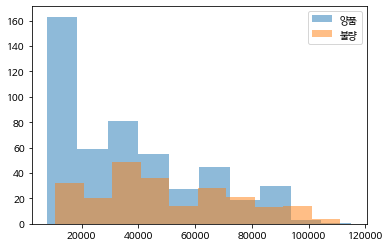

In [20]:
# plate 중량에 따른 양품/불량 수 
fun_plot_hist(df_raw,"PT_WGT")

#### plate 길이가 ~ 20000에서 약 20%이하의, 2000 ~ 30000에서 25%이하의 낮은 불량률을 보인다. 
#### >> 불량률을 낮추기 위해서는 plate의 길이를 20000이하로 하는 것이 좋다. 

### 2-3 Pie Chart와 Bar Chart로 양품 강종의 비율 밝히기 

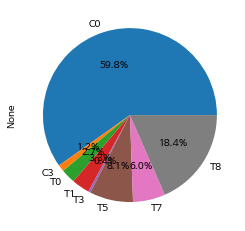

In [21]:
# 양품인 강종 데이터 프레임 만들기
df_true=df_raw[df_raw['SCALE']==0]

# 양품 강종 Pie Chart 
df_count=df_true.groupby(["STEEL_KIND"]).size()
df_count.plot.pie(y="OXY", autopct="%.1f%%")

#### Pie Chart로 양품 강종의 비율을 확인하였을 때 C0가 가장 높은 비율이 나왔다. 반면, 각 강종별 전체 갯수에 따른 양품의 갯수는 알 수 없으므로 확인하기 위해 bar chart를 구해보았다. 

In [22]:
# Bar chart 그리기 위한 함수 구현
def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()
    agg = { key : [ len(df[(df[rows]==value) & (df[columns]==key)]) for value in row_keys]
               for key in column_keys }
    aggdf = pd.DataFrame(agg,index = row_keys, columns={0:'양품', 1:'불량'})
    aggdf.index.rename(rows,inplace=True)
    return aggdf

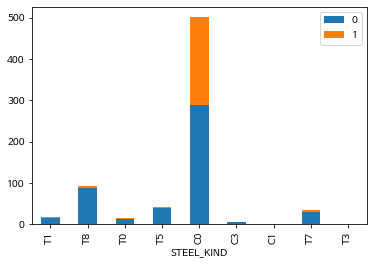

In [23]:
aggregate('STEEL_KIND', 'SCALE', df_raw).plot(kind='bar',stacked=True)

#### bar chart를 확인하였을 때, C0에서 불량품의 비율이 가장 높았다. 

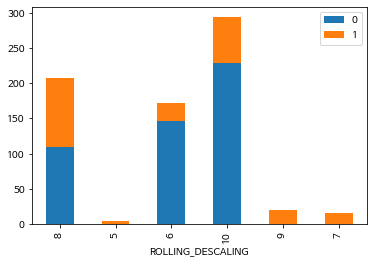

In [24]:
aggregate('ROLLING_DESCALING', 'SCALE', df_raw).plot(kind='bar', stacked=True)

#### 압연 중 Descaling 횟수가 홀수 일 때는 불량률이 100%이고, 짝수일 경우, 6,10,8 순으로 불량률이 낮았다. 

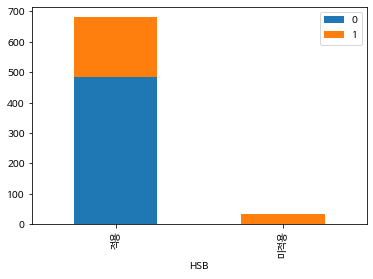

In [25]:
aggregate('HSB', 'SCALE', df_raw).plot(kind='bar', stacked=True)

#### HSB 미적용시 불량률이 100%가 되었다. 

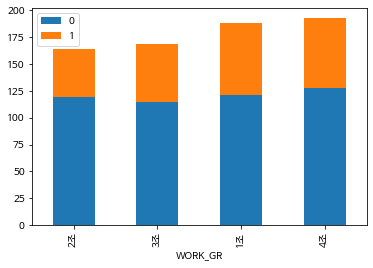

In [26]:
aggregate('WORK_GR', 'SCALE', df_raw).plot(kind='bar', stacked=True)

### 2-4 가열로에 다른 불량률 평가 

In [27]:
def fun_print_crosstab(data, var):
    print(pd.crosstab(index=data["SCALE"], columns=data[var]))
    print()
    print(pd.crosstab(index=data["SCALE"], columns=data[var], normalize="columns").round(3))

In [28]:
fun_print_crosstab(df_raw, "FUR_NO") 

FUR_NO  1호기  2호기  3호기
SCALE                
0       166  166  151
1        73   70   88

FUR_NO    1호기    2호기    3호기
SCALE                      
0       0.695  0.703  0.632
1       0.305  0.297  0.368


#### 가열로 호기번호에 따른 불량률을 조사해 보았다. 각 가열로에 따라서 불량률은 30%정도이며 순서는 3호기, 1호기, 2호기 순이었다. 

In [29]:
fun_print_crosstab(df_raw, "FUR_NO_ROW") 

FUR_NO_ROW    1    2
SCALE               
0           239  244
1           120  111

FUR_NO_ROW      1      2
SCALE                   
0           0.666  0.687
1           0.334  0.313


#### 각 가열로 호기번호에 따른 불량률은 약 30%정도이며 1번(33.1%), 2번(31%) 순이었다. 

In [30]:
fur_df=df_raw.pivot_table(index='FUR_NO', columns='FUR_NO_ROW', values='SCALE')
fur_df

FUR_NO_ROW,1,2
FUR_NO,,
1호기,0.353,0.258
2호기,0.292,0.302
3호기,0.358,0.378


#### 가열로의 특징에 따라 불량룰을 조사하였을 때 3호기의 2번에서 가장 높은 불량률(37.2%)을 보였다.  

# 3. 분류 모델 분석 

###  3-1 로지스틱 선형회귀 

#### 데이터 전처리 

In [31]:
# 데이터 분할 
df_train,df_test=train_test_split(df_raw,test_size=0.3,random_state=1234)
df_train,df_val=train_test_split(df_train,test_size=3/7,random_state=1234)
print('train data size:{}'.format(df_train.shape))
print('validation data size:{}'.format(df_val.shape))
print('test data size:{}'.format(df_test.shape))

train data size:(285, 17)
validation data size:(214, 17)
test data size:(215, 17)


In [32]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 719
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SCALE              714 non-null    int64  
 1   STEEL_KIND         714 non-null    object 
 2   PT_THK             714 non-null    float64
 3   PT_WDTH            714 non-null    int64  
 4   PT_LTH             714 non-null    int64  
 5   PT_WGT             714 non-null    int64  
 6   FUR_NO             714 non-null    object 
 7   FUR_NO_ROW         714 non-null    int64  
 8   FUR_HZ_TEMP        714 non-null    int64  
 9   FUR_HZ_TIME        714 non-null    int64  
 10  FUR_SZ_TEMP        714 non-null    int64  
 11  FUR_SZ_TIME        714 non-null    int64  
 12  FUR_TIME           714 non-null    int64  
 13  ROLLING_TEMP_T5    714 non-null    int64  
 14  HSB                714 non-null    object 
 15  ROLLING_DESCALING  714 non-null    int64  
 16  WORK_GR            714 non

#### 모델 및 회귀 계수 검토 

In [33]:
log_model=Logit.from_formula("""SCALE ~ C(STEEL_KIND)+PT_THK+
                               PT_WDTH+PT_LTH+PT_WGT+C(FUR_NO)+FUR_NO_ROW+FUR_HZ_TEMP+\
                               FUR_HZ_TIME+FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+\
                               ROLLING_TEMP_T5+C(HSB)+ROLLING_DESCALING+C(WORK_GR)"""
                             , df_train)
log_result=log_model.fit(method='bfgs')
print(log_result.summary()) # Df Model: 입력변수의 개수 / Coef를 통해 분석한다. 

         Current function value: 0.257840
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  285
Model:                          Logit   Df Residuals:                      260
Method:                           MLE   Df Model:                           24
Date:                Wed, 25 Nov 2020   Pseudo R-squ.:                  0.5883
Time:                        23:44:57   Log-Likelihood:                -73.484
converged:                      False   LL-Null:                       -178.51
Covariance Type:            nonrobust   LLR p-value:                 1.174e-31
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.2550     38.733     -0.007      

/home/piai/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/piai/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/piai/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/piai/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/piai/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


#### 성능 평가 

#### 로지스틱 회귀 분석 결과 성명력은 61.38%로 낮은편이며 0.05미만의 p-value로 설명할 수 있는 변수는 압연온도와 압연중 descaling 변수 정도이다. 
#### scale데이터는 선형 데이터가 아니므로 일반적으로 로지스틱 회귀분석으로 변수의 중요도를 평가하긴 어렵다. 

### 3-2 의사 결정 나무 

#### 데이터 전처리 

In [34]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy=pd.get_dummies(df_raw)

# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,...,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0,32.25,3707,15109,14180,1,1144,116,1133,59,...,0,1,0,0,0,1,0,1,0,0
1,0,32.25,3707,15109,14180,2,1144,122,1135,53,...,0,1,0,0,0,1,0,1,0,0
2,0,33.27,3619,19181,18130,1,1129,116,1121,55,...,1,0,1,0,0,1,0,0,1,0
3,0,33.27,3619,19181,18130,2,1152,125,1127,68,...,1,0,1,0,0,1,0,0,1,0
4,0,38.33,3098,13334,12430,1,1140,134,1128,48,...,1,0,0,1,0,1,1,0,0,0


In [35]:
# 설명변수, 목표변수 데이터 지정 
df_raw_x=df_raw_dummy.drop("SCALE", axis=1, inplace=False) 
df_raw_y=df_raw_dummy["SCALE"] 

In [36]:
# train, test, validation 데이터를 4:3:3 비율로 분할한다. 
df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df_raw_x,df_raw_y,test_size=0.3,random_state=1234)
df_train_x,df_val_x,df_train_y,df_val_y=train_test_split(df_train_x,df_train_y,test_size=3/7,random_state=1234)
print('train data X size:{}'.format(df_train_x.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('validation data X size:{}'.format(df_val_x.shape))
print('validation data Y size:{}'.format(df_val_y.shape))
print('test data X size:{}'.format(df_test_x.shape))
print('test data Y size:{}'.format(df_test_y.shape))

train data X size:(285, 30)
train data Y size:(285,)
validation data X size:(214, 30)
validation data Y size:(214,)
test data X size:(215, 30)
test data Y size:(215,)


#### 모델 생성 

In [37]:
tree_uncustomized=DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력 
print("Accuracy on training set:{:.3f}".format(tree_uncustomized.score(df_train_x,df_train_y)))

# Test 데이터 설명력 
print("Accuracy on test set:{:.3f}".format(tree_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set:1.000
Accuracy on test set:0.944


#### 초기 모델의 training의 정확도는 100%이고 test의 정확도는 95.3%로 데이터는 과적합되어 있다고 볼 수 있다. 

#### 파라미터 조정 : 최대 깊이 변경 

In [38]:
# train 및 test 설명력 결과 저장
train_score=[]
test_score=[]

# max_depth:최대 깊이 변경
para_depth=[depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=DecisionTreeClassifier(random_state=1234 ,max_depth=v_max_depth)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
# 결과 저장
df_score_depth=pd.DataFrame()
df_score_depth['MinSamplesLeaf']=para_depth
df_score_depth['TrainScore']=train_score
df_score_depth['TestScore']=test_score

# 모델 설명력 확인
df_score_depth.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.916,0.888
1,2,0.947,0.921
2,3,0.965,0.953
3,4,0.975,0.953
4,5,0.975,0.953
5,6,0.982,0.953
6,7,0.989,0.944
7,8,0.996,0.953
8,9,1.000,0.944
9,10,1.000,0.944


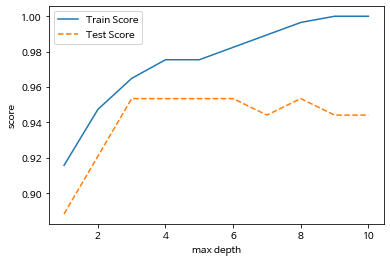

In [39]:
# 모델 설명력 그래프 확인
plt.plot(para_depth,train_score,linestyle='-',label='Train Score')
plt.plot(para_depth,test_score,linestyle='--',label='Test Score')
plt.ylabel('score')
plt.xlabel('max depth')
plt.legend()

#### 최대 깊이가 증가함에 따라 train 데이터의 정확도는 지속적으로 증가하는 반면, test 데이터의 정확도는 3에서 일정해진다. 
#### >> depth_max=3

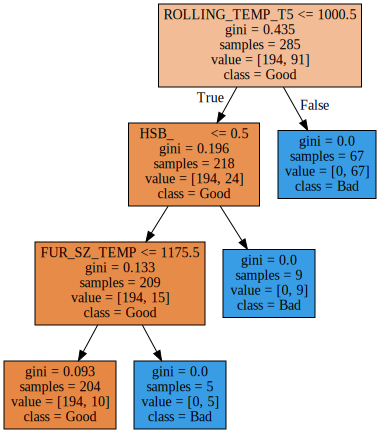

In [40]:
# 변수명 저장 
v_feature_name=df_train_x.columns

# 깊이가 4인 모델 
tree_low=DecisionTreeClassifier(max_depth=3, random_state=1234)
tree_low.fit(df_train_x,df_train_y)

# 트리 모델을 tree_low.dot 파일로 저장 (목표변수 0: Good, 1:Bad) 
export_graphviz(tree_low, out_file="tree_low.dot", class_names=["Good", "Bad"],\
               feature_names=v_feature_name, impurity=True, filled=True)

# graphviz를 이용해 트리 모델 시각화
with open("tree_low.dot") as f: 
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

#### 파라미터 조정 : 분리 노드의 최소 자료 수 변경

In [41]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# min_smaples_split
para_split=[n_split * 10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    tree=DecisionTreeClassifier(random_state=1234,min_samples_split=v_min_samples_split,\
                                max_depth=4)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_split=pd.DataFrame()
df_accuracy_split['MinSamplesLeaf']=para_split
df_accuracy_split['TrainAccuracy']=train_accuracy
df_accuracy_split['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_split.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.975,0.953
1,20,0.975,0.953
2,30,0.975,0.953
3,40,0.975,0.953
4,50,0.975,0.953
5,60,0.975,0.953
6,70,0.975,0.953
7,80,0.975,0.953
8,90,0.975,0.953
9,100,0.975,0.953


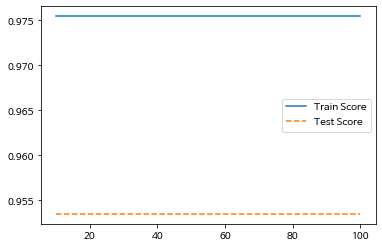

In [42]:
# 모델 설명력 그래프 확인
plt.plot(para_split,train_accuracy,linestyle='-',label='Train Score')
plt.plot(para_split,test_accuracy,linestyle='--',label='Test Score')
plt.legend()

#### >> 분리 노드의 최소 자료 수와 관계 없이 모델의 정확도는 일정하여, 해당 파라미터는 고려하지 않기로 한다. 

#### 파라미터 조정 : 잎사귀 노드의 최소 자료 수 변경

In [43]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# min_smaples_split: 분할하기 위한 노드의 최소 샘플수 
para_leaf=[n_leaf * 2 for n_leaf in range(1,11)] # 참조 : para_leaf:[2,4,6,...20]

for v_min_samples_leaf in para_leaf:
    tree=DecisionTreeClassifier(random_state=1234,min_samples_leaf=v_min_samples_leaf,\
                            min_samples_split=20,max_depth=4)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_leaf=pd.DataFrame()
df_accuracy_leaf['MinSamplesLeaf']=para_leaf
df_accuracy_leaf['TrainAccuracy']=train_accuracy
df_accuracy_leaf['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,2,0.975,0.953
1,4,0.965,0.953
2,6,0.958,0.949
3,8,0.947,0.921
4,10,0.916,0.888
5,12,0.916,0.888
6,14,0.916,0.888
7,16,0.916,0.888
8,18,0.916,0.888
9,20,0.916,0.888


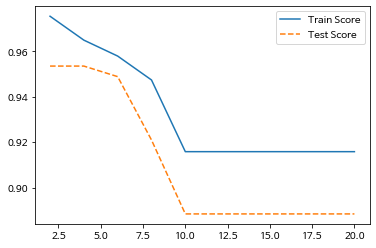

In [44]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf,train_accuracy,linestyle='-',label='Train Score')
plt.plot(para_leaf,test_accuracy,linestyle='--',label='Test Score')
plt.legend()

#### 잎사귀 노드의 최소 자료 수가 증가할수록 정확도는 감소한다. 
#### min_samples_leaf=4 

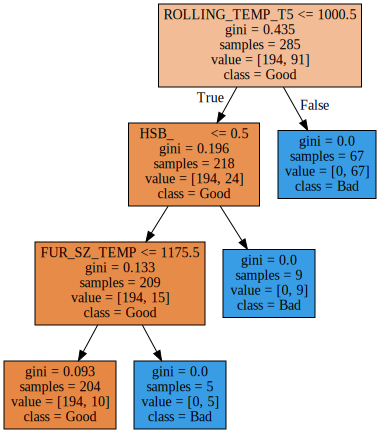

In [45]:
# 잎사귀 노드의 최소 사료 수가 4인 무델 
tree_low=DecisionTreeClassifier(random_state=1234,min_samples_leaf=4,max_depth=3)
tree_low.fit(df_train_x,df_train_y)

export_graphviz(tree_low,out_file='tree_low.dot',class_names=["Good","Bad"],\
               feature_names=v_feature_name,impurity=True,filled=True)

with open('tree_low.dot') as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

#### 파라미터 조정 : GridSearchCV를 이용한 최적 parameter 찾기 

In [46]:
estimator=DecisionTreeClassifier()

# 구하고자 하는 parameter와 범위
param_grid={'max_depth':para_depth,'min_samples_leaf':para_leaf,\
            'min_samples_split': para_split}

# 설명력이 높은 최적 parameter 찾기
grid_dt=GridSearchCV(estimator,param_grid,scoring='accuracy',n_jobs=-1)
grid_dt.fit(df_test_x,df_test_y)

print('best estimator model:\n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter:\n{}'.format(grid_dt.best_params_))
print('\nbest score:\n{}'.format(grid_dt.best_score_.round(3)))

best estimator model:
DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=20)

best parameter:
{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 20}

best score:
0.953


#### 최종 모델 선택 

In [47]:
# 최종 모델 
tree_final=DecisionTreeClassifier(random_state=1234, max_depth=3, min_samples_leaf=4)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=4, random_state=1234)

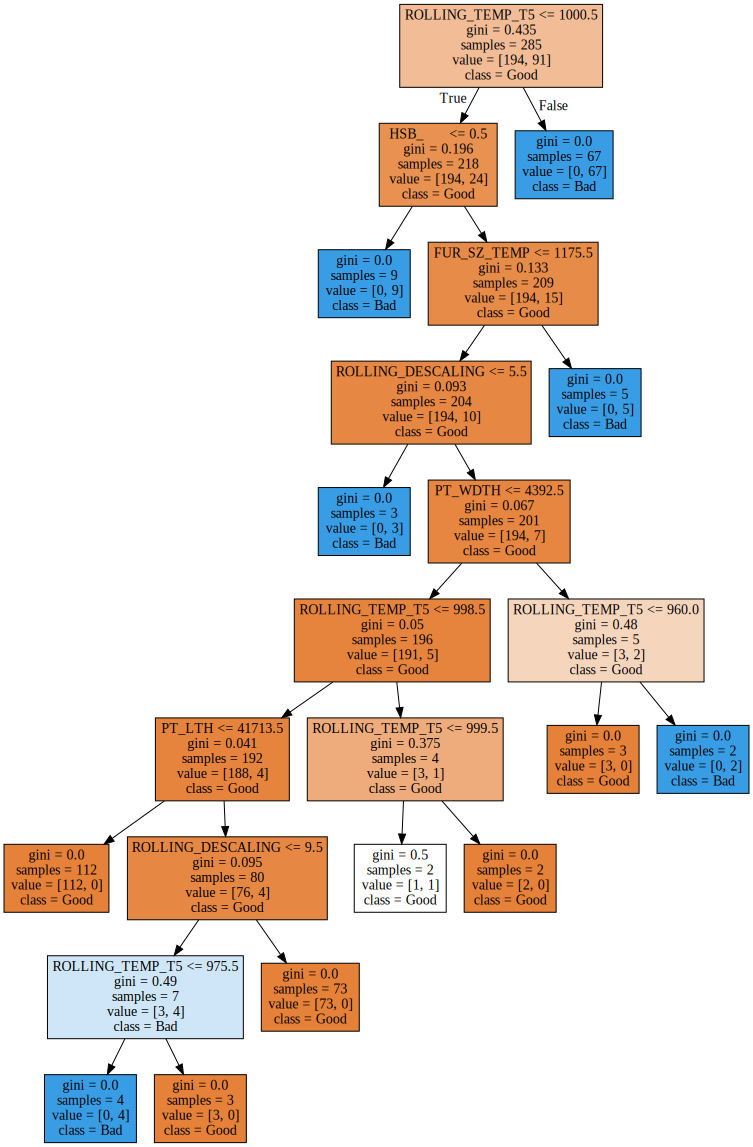

In [116]:
# tree_final.dot으로 결과 저장 
export_graphviz(tree_final, out_file="tree_final.dot", class_names=["Good","Bad"],\
               feature_names=v_feature_name, impurity=True, filled=True)

# tree_final.dot 그리기
with open("tree_final.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [117]:
import pydot
(graph,) = pydot.graph_from_dot_file('tree_low.dot',encoding='utf8')
graph.write_png('decisionTree.png')

In [49]:
# 평가 
y_pred=tree_final.predict(df_test_x)
print("Accuracy:{:.3f}".format(tree_final.score(df_train_x,df_train_y)))
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y,y_pred)))

Accuracy:0.965
Confusion matrix:
[[144   0]
 [ 10  61]]


#### 모델의 정확도는 96.5%이다. 
#### Confusion Matrix 결과 모델은 실제로 불량인 제품을 양품으로 판정활 확률은 14%로 정확도 향상을 위해 파라미터의 변경이나 데이터의 추가가 필요하다. 

#### GridSeachCV를 이용한 최적 parameter와 비교 

In [50]:
# GridSearchCV결과에 따른 모델 
tree_final_1=DecisionTreeClassifier(random_state=1234, max_depth=7, min_samples_leaf=4,\
                                  min_samples_split=20)
tree_final_1.fit(df_train_x,df_train_y)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=20,
                       random_state=1234)

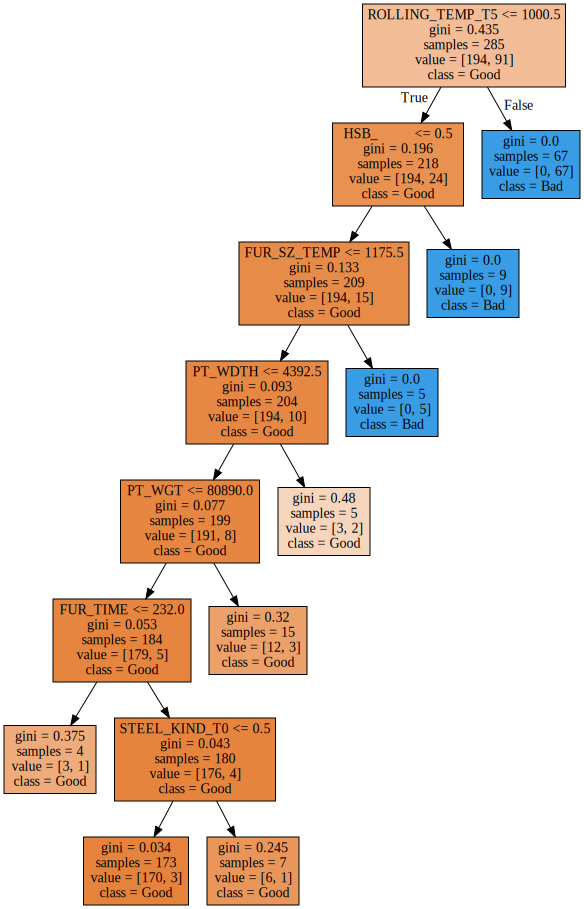

In [51]:
# tree_final.dot으로 결과 저장 
export_graphviz(tree_final_1, out_file="tree_final_1.dot", class_names=["Good","Bad"],\
               feature_names=v_feature_name, impurity=True, filled=True)

# tree_final.dot 그리기
with open("tree_final_1.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [52]:
# 평가 
y_pred=tree_final_1.predict(df_test_x)
print("Accuracy:{:.3f}".format(tree_final.score(df_train_x,df_train_y)))
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y,y_pred)))

Accuracy:0.965
Confusion matrix:
[[144   0]
 [ 10  61]]


#### 정확도 분석 결과, 최종 모델과 GridSearchCV를 활용한 모델의 정확도는 차이를 보이지 않는다. 
#### 따라서, 최종 모델을 채택하기로 한다. 

#### 중요 변수 (Vital Few 찾기)

In [53]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance.round(3)
df_importance_10=df_importance[0:10]

<ipython-input-54-500cd8894b48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importance_10.sort_values('Importance',ascending=True,inplace=True)


Text(0, 0.5, '변수')

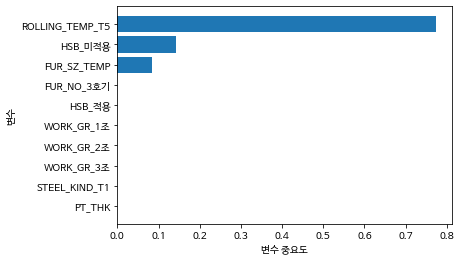

In [54]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance_10.sort_values('Importance',ascending=True,inplace=True)
coordinates=range(len(df_importance_10))
plt.barh(y=coordinates,width=df_importance_10['Importance'])
plt.yticks(coordinates,df_importance_10['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

#### 설명 변수의 중요도를 평가한 결과, 압연온도, HSB 적용 여부, 가열로 균열대 온도가 중요 설명변수임을 알 수 있다. 

### 3-3 랜덤 포래스트 

#### 데이터 전처리 

In [55]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy=pd.get_dummies(df_raw)

# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,...,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0,32.25,3707,15109,14180,1,1144,116,1133,59,...,0,1,0,0,0,1,0,1,0,0
1,0,32.25,3707,15109,14180,2,1144,122,1135,53,...,0,1,0,0,0,1,0,1,0,0
2,0,33.27,3619,19181,18130,1,1129,116,1121,55,...,1,0,1,0,0,1,0,0,1,0
3,0,33.27,3619,19181,18130,2,1152,125,1127,68,...,1,0,1,0,0,1,0,0,1,0
4,0,38.33,3098,13334,12430,1,1140,134,1128,48,...,1,0,0,1,0,1,1,0,0,0


In [56]:
# 설명변수, 목표변수 데이터 지정 
df_raw_x=df_raw_dummy.drop("SCALE", axis=1, inplace=False) 
df_raw_y=df_raw_dummy["SCALE"] 

In [57]:
# train, test, validation 데이터를 4:3:3 비율로 분할한다. 
df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df_raw_x,df_raw_y,test_size=0.3,random_state=1234)
df_train_x,df_val_x,df_train_y,df_val_y=train_test_split(df_train_x,df_train_y,test_size=3/7,random_state=1234)
print('train data X size:{}'.format(df_train_x.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('validation data X size:{}'.format(df_val_x.shape))
print('validation data Y size:{}'.format(df_val_y.shape))
print('test data X size:{}'.format(df_test_x.shape))
print('test data Y size:{}'.format(df_test_y.shape))

train data X size:(285, 30)
train data Y size:(285,)
validation data X size:(214, 30)
validation data Y size:(214,)
test data X size:(215, 30)
test data Y size:(215,)


#### 모델 생성 

In [58]:
# 랜덤 포레스트 생성 : RandomForestClassifer
rf_uncustomized=RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력 
print("Accuracy on training set:{:.3f}".format(rf_uncustomized.score(df_train_x,df_train_y)))

# Test 데이터 설명력 
print("Accuracy on test set:{:.3f}".format(rf_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set:1.000
Accuracy on test set:0.930


#### 초기 모델의 training의 정확도는 100%이고 test의 정확도는 93%로 데이터는 과적합되어 있다고 볼 수 있다. 

#### 파라미터 조정 : 트리수 변경

In [59]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# n_estimators
para_n_tree=[n_tree*10 for n_tree in range(1,16)] 

for v_n_estimators in para_n_tree:
    rf=RandomForestClassifier(random_state=1234,n_estimators=v_n_estimators)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_n=pd.DataFrame()
df_accuracy_n['n_estimators']=para_n_tree
df_accuracy_n['TrainAccuracy']=train_accuracy
df_accuracy_n['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.993,0.921
1,20,0.996,0.935
2,30,1.000,0.912
3,40,1.000,0.930
4,50,1.000,0.921
5,60,1.000,0.930
6,70,1.000,0.930
7,80,1.000,0.935
8,90,1.000,0.940
9,100,1.000,0.930


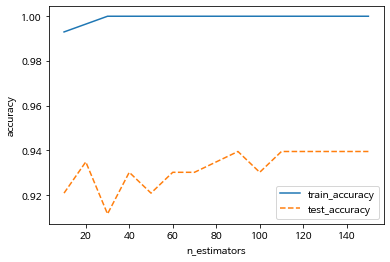

In [60]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree,train_accuracy,linestyle='-',label='train_accuracy')
plt.plot(para_n_tree,test_accuracy,linestyle='--',label='test_accuracy')
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.legend()

#### 트리수가 30이상에서는 train test의 정확도 30%로 일정하고 test정확도는 큰폭으로 변동하며 증가하다 110개에서 일정해진다.  
#### >> n_estimators는 110 이상의 값을 선택하기로 한다. 

#### 파라미터 조정 : 트리수 변경에 따른 모델 oob error 변화

In [61]:
# error 저장 리스트 
oob_error=[]

for v_n_estimator in range(1,151):
    rf=RandomForestClassifier(n_estimators=v_n_estimator, oob_score=True, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1-rf.oob_score_)

/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This prob

Text(0.5, 0, 'n_estimators')

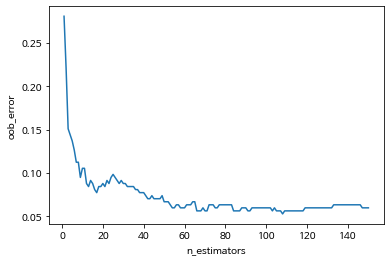

In [62]:
# 그래프로 표현
plt.plot(range(1,151), oob_error)
plt.ylabel("oob_error")
plt.xlabel("n_estimators")

#### 생성하는 결정 트리수의 증가에 따라 oob_error는 감소하다 일정해진다. 
#### 앞의 결과과 종합하였을 때 트리수는 110개로 선택한다. 
#### >> n_estimators=110

#### 파라미터 조정 : 최대 깊이 변경에 따른 모델 성능 변화 

In [63]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# max_depth: 최대 깊이 변경
para_depth=[depth for depth in range(1,11)] 

for v_max_depth in para_depth:
    rf=RandomForestClassifier(random_state=1234,n_estimators=110, max_depth=v_max_depth)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_depth=pd.DataFrame()
df_accuracy_depth['Depthdepth']= para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_depth.round(3)

,Depthdepth,TrainAccuracy,TestAccuracy
0,1,0.874,0.823
1,2,0.923,0.879
2,3,0.944,0.912
3,4,0.954,0.916
4,5,0.965,0.930
5,6,0.975,0.944
6,7,0.989,0.944
7,8,0.993,0.935
8,9,1.000,0.940
9,10,1.000,0.944


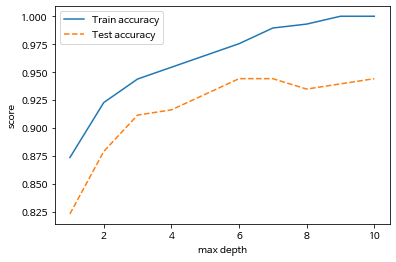

In [64]:
# 모델 설명력 그래프 확인
plt.plot(para_depth,train_accuracy,linestyle='-',label='Train accuracy')
plt.plot(para_depth,test_accuracy,linestyle='--',label='Test accuracy')
plt.ylabel('score')
plt.xlabel('max depth')
plt.legend()

#### 최대 깊이 증가에 따라 모델의 정확도는 증가하며 train/test 데이터의 성능 변화를 고려하여 7을 선택한다. 

#### max_depth = 7

#### 파라미터 조정 : 분리 노드의 최소 자료 수 변경에 따른 모델 성능 변화

In [65]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# min_samples_split : 분할하기 위한 노드의 최소 샘플 수 
para_split=[n_split*10 for n_split in range(1,11)] 
for v_min_samples_split in para_split:
    rf=RandomForestClassifier(random_state=1234,n_estimators=110, max_depth=7 \
                              ,min_samples_split=v_min_samples_split)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_depth=pd.DataFrame()
df_accuracy_depth['MinSamplesSplit']= para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_depth.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,1,0.968,0.930
1,2,0.965,0.940
2,3,0.961,0.921
3,4,0.961,0.926
4,5,0.958,0.907
5,6,0.944,0.898
6,7,0.944,0.893
7,8,0.933,0.888
8,9,0.926,0.888
9,10,0.926,0.884


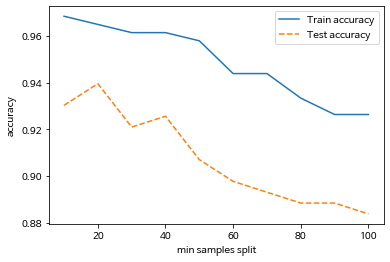

In [66]:
# 모델 설명력 그래프 확인
plt.plot(para_split,train_accuracy,linestyle='-',label='Train accuracy')
plt.plot(para_split,test_accuracy,linestyle='--',label='Test accuracy')
plt.ylabel('accuracy')
plt.xlabel('min samples split')
plt.legend()

#### 분리 노드의 최소 자료 수 증가에 따라 모델의 정확도는 감소하며, train/test 모델의 정확도를 고려하여 분리 노드의 최소 자료 수를 20으로 정한다. 
#### min_samples_split = 20

#### 파라미터 조정 : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능 변화

In [67]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# min_samples_split : 분할하기 위한 노드의 최소 샘플 수 
para_leaf=[n_leaf*10 for n_leaf in range(1,11)] 

for v_min_samples_leaf in para_leaf:
    rf=RandomForestClassifier(random_state=1234,n_estimators=110, max_depth=7, \
                              min_samples_split=20,min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_depth=pd.DataFrame()
df_accuracy_depth['MinSamplesSplit']= para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_depth.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,1,0.916,0.879
1,2,0.912,0.884
2,3,0.912,0.884
3,4,0.909,0.870
4,5,0.895,0.828
5,6,0.695,0.684
6,7,0.681,0.670
7,8,0.681,0.670
8,9,0.681,0.670
9,10,0.681,0.670


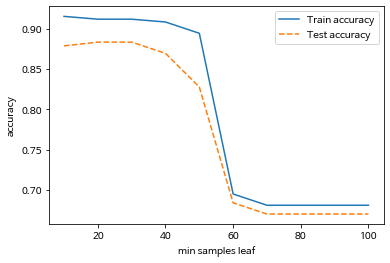

In [68]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf,train_accuracy,linestyle='-',label='Train accuracy')
plt.plot(para_leaf,test_accuracy,linestyle='--',label='Test accuracy')
plt.ylabel('accuracy')
plt.xlabel('min samples leaf')
plt.legend()

#### 잎사귀 노드 최소 자료 수 증가에 따라 모델의 정확도는 감소하며, Train/test 데이터의 성능 변화를 고려하여 20을 선택한다 .
#### min samples leaf = 20

#### 최종 모델 선택

In [69]:
# 최종 모델 
rf_final=RandomForestClassifier(random_state=1234,n_estimators=110, max_depth=7, \
                              min_samples_split=20,min_samples_leaf=20)
rf_final.fit(df_train_x,df_train_y)

# 평가 
y_pred=rf_final.predict(df_test_x)

# Train 데이터 설명력 
print("Accuracy on training set:{:.3f}".format(rf_final.score(df_train_x,df_train_y)))

# Test 데이터 설명력 
print("Accuracy on test set:{:.3f}".format(rf_final.score(df_test_x,df_test_y)))

# Confusion matrix
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y,y_pred)))


Accuracy on training set:0.912
Accuracy on test set:0.884
Confusion matrix:
[[144   0]
 [ 25  46]]


#### 정확도는 train set의 경우 91.2% test set의 경우 88.4%로 초기 모델에 비해 감소했다
#### Confusion Matrix 결과 모델은 실제로 불량인 제품을 양품으로 판정활 확률은 35.2%로 모델은 불량품을 분류하기에 부적절하다. 

#### 파라미터 조정 : GirdSearchCV를 이용한 최적 parameter 찾기

In [70]:
estimator=RandomForestClassifier(random_state=1234,n_estimators=110)

# 구하고자 하는 parameter와 범위
param_grid={'max_depth':para_depth,'min_samples_leaf':para_leaf}

# 설명력이 높은 최적 parameter 찾기
grid_rf=GridSearchCV(estimator,param_grid,scoring='accuracy',n_jobs=-1)
grid_rf.fit(df_test_x,df_test_y)

print('best estimator model:\n{}'.format(grid_rf.best_estimator_))
print('\nbest parameter:\n{}'.format(grid_rf.best_params_))
print('\nbest score:\n{}'.format(grid_rf.best_score_.round(3)))

best estimator model:
RandomForestClassifier(max_depth=2, min_samples_leaf=10, n_estimators=110,
                       random_state=1234)

best parameter:
{'max_depth': 2, 'min_samples_leaf': 10}

best score:
0.879


In [71]:
# 최종 모델 
rf_final=RandomForestClassifier(random_state=1234,n_estimators=110, max_depth=2, min_samples_leaf=20)
rf_final.fit(df_train_x,df_train_y)

# 평가 
y_pred=rf_final.predict(df_test_x)

# Train 데이터 설명력 
print("Accuracy on training set:{:.3f}".format(rf_final.score(df_train_x,df_train_y)))

# Test 데이터 설명력 
print("Accuracy on test set:{:.3f}".format(rf_final.score(df_test_x,df_test_y)))

# Confusion matrix
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y,y_pred)))


Accuracy on training set:0.912
Accuracy on test set:0.874
Confusion matrix:
[[144   0]
 [ 27  44]]


#### GridSearchCV를 활용한 정확도는 train set의 경우 91.2% test set의 경우 87.4%로 초기 모델과 수정 모델에 비해 감소했다. 
#### Confusion Matrix 결과 모델은 실제로 불량인 제품을 양품으로 판정활 확률은 38%로 모델은 불량품을 분류하기에 부적절하다. 

#### 중요 변수 (Vital Few 찾기)

In [72]:
# 변수명
v_feature_name=df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance_10=df_importance[0:10]
df_importance_10.round(3)

,Feature,Importance
10,ROLLING_TEMP_T5,0.305
0,PT_THK,0.113
1,PT_WDTH,0.112
7,FUR_SZ_TEMP,0.110
5,FUR_HZ_TEMP,0.072
2,PT_LTH,0.065
3,PT_WGT,0.055
11,ROLLING_DESCALING,0.043
12,STEEL_KIND_C0,0.040
9,FUR_TIME,0.038


<ipython-input-73-500cd8894b48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importance_10.sort_values('Importance',ascending=True,inplace=True)


Text(0, 0.5, '변수')

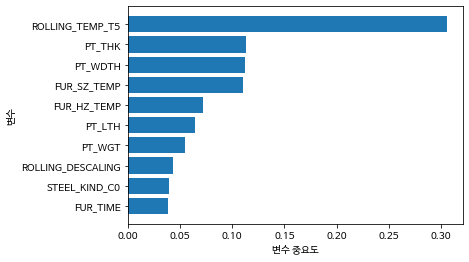

In [73]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance_10.sort_values('Importance',ascending=True,inplace=True)
coordinates=range(len(df_importance_10))
plt.barh(y=coordinates,width=df_importance_10['Importance'])
plt.yticks(coordinates,df_importance_10['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

#### 설명 변수의 중요도를 평가한 결과, 압연온도, plate의 두께, plate의 폭, 가열로 균열대 온도가 중요 설명변수임을 알 수 있다.

### 3-4 그래디언트 부스팅

#### 데이터 전처리 

In [74]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy=pd.get_dummies(df_raw)

# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,...,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0,32.25,3707,15109,14180,1,1144,116,1133,59,...,0,1,0,0,0,1,0,1,0,0
1,0,32.25,3707,15109,14180,2,1144,122,1135,53,...,0,1,0,0,0,1,0,1,0,0
2,0,33.27,3619,19181,18130,1,1129,116,1121,55,...,1,0,1,0,0,1,0,0,1,0
3,0,33.27,3619,19181,18130,2,1152,125,1127,68,...,1,0,1,0,0,1,0,0,1,0
4,0,38.33,3098,13334,12430,1,1140,134,1128,48,...,1,0,0,1,0,1,1,0,0,0


In [75]:
# 설명변수, 목표변수 데이터 지정 
df_raw_x=df_raw_dummy.drop("SCALE", axis=1, inplace=False) 
df_raw_y=df_raw_dummy["SCALE"] 

In [76]:
# train, test, validation 데이터를 4:3:3 비율로 분할한다. 
df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df_raw_x,df_raw_y,test_size=0.3,random_state=1234)
df_train_x,df_val_x,df_train_y,df_val_y=train_test_split(df_train_x,df_train_y,test_size=3/7,random_state=1234)
print('train data X size:{}'.format(df_train_x.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('validation data X size:{}'.format(df_val_x.shape))
print('validation data Y size:{}'.format(df_val_y.shape))
print('test data X size:{}'.format(df_test_x.shape))
print('test data Y size:{}'.format(df_test_y.shape))

train data X size:(285, 30)
train data Y size:(285,)
validation data X size:(214, 30)
validation data Y size:(214,)
test data X size:(215, 30)
test data Y size:(215,)


#### 초기 모델 생성

In [77]:
# 그래디언트 부스팅 생성 : GradientBoostingClassifer
gb_uncustomized=GradientBoostingClassifier(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력 
print("Accuracy on training set:{:.3f}".format(gb_uncustomized.score(df_train_x,df_train_y)))

# Test 데이터 설명력 
print("Accuracy on test set:{:.3f}".format(gb_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set:1.000
Accuracy on test set:0.949


#### 초기 모델의 training의 정확도는 100%이고 test의 정확도는 94.9%로 데이터는 과적합되어 있다고 볼 수 있다. 

#### 파라미터 조정 :  학습률 변경에 따른 모델 성능 

In [78]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# learning_rate 학습률 변경: 0.1~0.9 
para_lr=[lr*0.1 for lr in range(1,10)] 

for v_learning_rate in para_lr:
    gb=GradientBoostingClassifier(random_state=1234,learning_rate=v_learning_rate)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_lr=pd.DataFrame()
df_accuracy_lr['learning_rate']=para_lr
df_accuracy_lr['TrainAccuracy']=train_accuracy
df_accuracy_lr['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_lr.round(3)

,learning_rate,TrainAccuracy,TestAccuracy
0,0.1,1.0,0.949
1,0.2,1.0,0.953
2,0.3,1.0,0.949
3,0.4,1.0,0.958
4,0.5,1.0,0.958
5,0.6,1.0,0.972
6,0.7,1.0,0.958
7,0.8,1.0,0.958
8,0.9,1.0,0.953


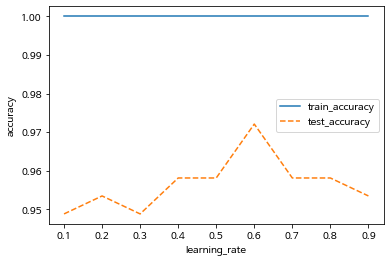

In [79]:
# 모델 설명력 그래프 확인
plt.plot(para_lr,train_accuracy,linestyle='-',label='train_accuracy')
plt.plot(para_lr,test_accuracy,linestyle='--',label='test_accuracy')
plt.ylabel('accuracy')
plt.xlabel('learning_rate')
plt.legend()

#### Train test 정확도는 항상 100%로 과대 적합되어 있다. 
#### Train/test 데이터의 성능 변화를 고려하였을 때, learning_rate가 0.6일 때 가장 적합하다. 
#### learning_rate=0.6

#### 파라미터 조정 : 트리수 변경에 따른 모델 성능 

In [80]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# n_estimators: 트리 수 변경: 1~150 
para_n_tree=[n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    gb=GradientBoostingClassifier(random_state=1234,learning_rate=0.6, \
                              n_estimators=v_n_estimators)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_n=pd.DataFrame()
df_accuracy_n['n_estimators']=para_n_tree
df_accuracy_n['TrainAccuracy']=train_accuracy
df_accuracy_n['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,1.0,0.953
1,20,1.0,0.958
2,30,1.0,0.963
3,40,1.0,0.963
4,50,1.0,0.963
5,60,1.0,0.963
6,70,1.0,0.963
7,80,1.0,0.963
8,90,1.0,0.972
9,100,1.0,0.972


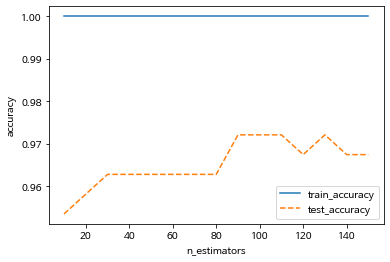

In [81]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree,train_accuracy,linestyle='-',label='train_accuracy')
plt.plot(para_n_tree,test_accuracy,linestyle='--',label='test_accuracy')
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.legend()

#### Train test 정확도는 트리수가 30개 이상일 때는 100%로 일정하다. 
#### Train/test 데이터의 성능 변화를 고려하였을 때, 트리 수가 100개일 때 가장 적합하다. 
#### n_estimators=100

#### 파라미터 조정 : 최대 깊이 변경에 따른 모델 성능 

In [82]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# max_depth: 최대 깊이 변경
para_depth=[depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb=GradientBoostingClassifier(random_state=1234,n_estimators=100, learning_rate=0.6,\
                                  max_depth=v_max_depth)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_depth=pd.DataFrame()
df_accuracy_depth['Depthdepth']= para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_depth.round(3)

,Depthdepth,TrainAccuracy,TestAccuracy
0,1,1.0,0.958
1,2,1.0,0.972
2,3,1.0,0.972
3,4,1.0,0.963
4,5,1.0,0.958
5,6,1.0,0.958
6,7,1.0,0.916
7,8,1.0,0.902
8,9,1.0,0.940
9,10,1.0,0.940


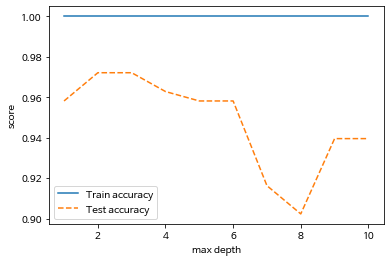

In [83]:
# 모델 설명력 그래프 확인
plt.plot(para_depth,train_accuracy,linestyle='-',label='Train accuracy')
plt.plot(para_depth,test_accuracy,linestyle='--',label='Test accuracy')
plt.ylabel('score')
plt.xlabel('max depth')
plt.legend()

#### Train test 정확도는 100%로 일정하다. 
#### Train/test 데이터의 성능 변화를 고려하였을 때, 최대 깊이가 3일 때 가장 적합하다. 
#### max_depth=3

#### 파라미터 조정 : 분리 노드의 최소 자료 수 변경에 따른 모델 성능 

In [84]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# min_samples_split : 분할하기 위한 노드의 최소 샘플 수 
para_split=[n_split*10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    gb=GradientBoostingClassifier(random_state=1234,n_estimators=100, max_depth=3 \
                              ,learning_rate=0.6,min_samples_split=v_min_samples_split)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_depth=pd.DataFrame()
df_accuracy_depth['MinSamplesSplit']= para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_depth.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,1,1.0,0.958
1,2,1.0,0.958
2,3,1.0,0.972
3,4,1.0,0.972
4,5,1.0,0.972
5,6,1.0,0.972
6,7,1.0,0.972
7,8,1.0,0.972
8,9,1.0,0.967
9,10,1.0,0.972


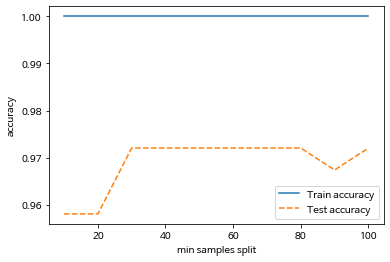

In [85]:
# 모델 설명력 그래프 확인
plt.plot(para_split,train_accuracy,linestyle='-',label='Train accuracy')
plt.plot(para_split,test_accuracy,linestyle='--',label='Test accuracy')
plt.ylabel('accuracy')
plt.xlabel('min samples split')
plt.legend()

#### Train test 정확도는 100%로 일정하다. 
#### Train/test 데이터의 성능 변화를 고려하였을 때, 분리 노드 최소 자료수가 30개일 때 가장 적합하다. 
#### min samples split=30

#### 파라미터 조정 : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [86]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# min_samples_split : 분할하기 위한 노드의 최소 샘플 수 
para_leaf=[n_leaf*10 for n_leaf in range(1,11)] 

for v_min_samples_leaf in para_leaf:
    gb=GradientBoostingClassifier(random_state=1234,n_estimators=100, max_depth=3 \
                                  ,learning_rate=0.6,min_samples_split=30,\
                                  min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_depth=pd.DataFrame()
df_accuracy_depth['MinSamplesSplit']= para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_depth.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,1,1.000,0.958
1,2,1.000,0.884
2,3,1.000,0.879
3,4,1.000,0.884
4,5,1.000,0.874
5,6,1.000,0.856
6,7,0.989,0.870
7,8,0.965,0.847
8,9,0.933,0.795
9,10,0.863,0.795


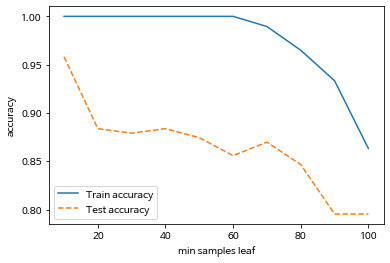

In [87]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf,train_accuracy,linestyle='-',label='Train accuracy')
plt.plot(para_leaf,test_accuracy,linestyle='--',label='Test accuracy')
plt.ylabel('accuracy')
plt.xlabel('min samples leaf')
plt.legend()

#### 보다 정확한 평가를 위해 설명력 test를 재시행한다. 

In [88]:
# train 밒 test 정확도 결과 저장용
train_accuracy=[]; test_accuracy=[]

# min_samples_split : 분할하기 위한 노드의 최소 샘플 수 
para_leaf=[n_leaf for n_leaf in range(1,11)] 

for v_min_samples_leaf in para_leaf:
    gb=GradientBoostingClassifier(random_state=1234,n_estimators=100, max_depth=3 \
                                  ,learning_rate=0.6,min_samples_split=30,\
                                  min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_depth=pd.DataFrame()
df_accuracy_depth['MinSamplesSplit']= para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_depth.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,1,1.0,0.972
1,2,1.0,0.977
2,3,1.0,0.967
3,4,1.0,0.977
4,5,1.0,0.991
5,6,1.0,0.972
6,7,1.0,0.967
7,8,1.0,0.958
8,9,1.0,0.953
9,10,1.0,0.958


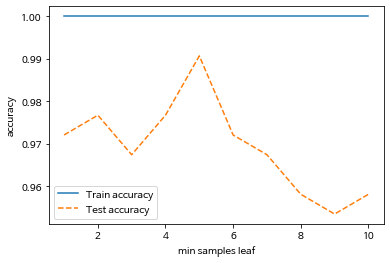

In [89]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf,train_accuracy,linestyle='-',label='Train accuracy')
plt.plot(para_leaf,test_accuracy,linestyle='--',label='Test accuracy')
plt.ylabel('accuracy')
plt.xlabel('min samples leaf')
plt.legend()

#### Train test 정확도는 100%로에서 잎사귀 노드의 최소 자료 수가 60개 이상일 때 감소하기 시작한다.  
#### Train/test 데이터의 성능 변화를 고려하였을 때, 잎사귀 노드의 최소 자료수가 5개일 때 가장 적합하다. 
#### min samples leaf=5

#### 최종 모델 

In [90]:
# 최종 모델 
gb_final=GradientBoostingClassifier(random_state=1234,n_estimators=100, max_depth=3, \
                              min_samples_split=30,min_samples_leaf=5,learning_rate=0.6)
gb_final.fit(df_train_x,df_train_y)

# 평가 
y_pred=gb_final.predict(df_test_x)

# Train 데이터 설명력 
print("Accuracy on training set:{:.3f}".format(gb_final.score(df_train_x,df_train_y)))

# Test 데이터 설명력 
print("Accuracy on test set:{:.3f}".format(gb_final.score(df_test_x,df_test_y)))

# Confusion matrix
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y,y_pred)))


Accuracy on training set:1.000
Accuracy on test set:0.991
Confusion matrix:
[[142   2]
 [  0  71]]


#### 정확도는 train set의 경우 100%, test set의 경우 99.1%로 초기 모델에 비해 증가했다
#### Confusion Matrix 결과 모델은 실제로 불량인 제품을 양품으로 판정활 확률은 0%로 모델은 불량품을 분류하기에 적절하다.  

#### 최종 모델 평가 결과 

In [91]:
# 변수명
v_feature_name=df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance_10=df_importance[0:10]
df_importance_10.round(3)

,Feature,Importance
10,ROLLING_TEMP_T5,0.702
25,HSB_적용,0.110
7,FUR_SZ_TEMP,0.081
11,ROLLING_DESCALING,0.026
24,HSB_미적용,0.021
0,PT_THK,0.020
1,PT_WDTH,0.013
3,PT_WGT,0.013
9,FUR_TIME,0.006
8,FUR_SZ_TIME,0.003


<ipython-input-92-500cd8894b48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importance_10.sort_values('Importance',ascending=True,inplace=True)


Text(0, 0.5, '변수')

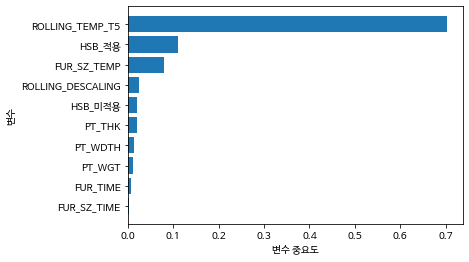

In [92]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance_10.sort_values('Importance',ascending=True,inplace=True)
coordinates=range(len(df_importance_10))
plt.barh(y=coordinates,width=df_importance_10['Importance'])
plt.yticks(coordinates,df_importance_10['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

#### 설명 변수의 중요도를 평가한 결과, 압연온도가 70%의 중요도를 갖고 HSB 적용여부와 가열로 균열대 온도 순으로 중요도가 높다. 

# 4. 중요도 높은 변수로 의사 결정 나무 

#### 데이터 전처리 

In [93]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy=pd.get_dummies(df_raw)

# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,...,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0,32.25,3707,15109,14180,1,1144,116,1133,59,...,0,1,0,0,0,1,0,1,0,0
1,0,32.25,3707,15109,14180,2,1144,122,1135,53,...,0,1,0,0,0,1,0,1,0,0
2,0,33.27,3619,19181,18130,1,1129,116,1121,55,...,1,0,1,0,0,1,0,0,1,0
3,0,33.27,3619,19181,18130,2,1152,125,1127,68,...,1,0,1,0,0,1,0,0,1,0
4,0,38.33,3098,13334,12430,1,1140,134,1128,48,...,1,0,0,1,0,1,1,0,0,0


In [94]:
# 설명변수, 목표변수 데이터 지정 
df_raw_x=df_raw_dummy.drop(["SCALE","PT_WGT","FUR_HZ_TIME","FUR_SZ_TIME",\
                      "FUR_TIME"], axis=1, inplace=False) # 목표변수와 의미 없는 변수는 삭제한다. 
df_raw_y=df_raw["SCALE"] # 목표 변수를 0,1로 바꾼다. 

In [95]:
# train, test, validation 데이터를 4:3:3 비율로 분할한다. 
df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df_raw_x,df_raw_y,test_size=0.3,random_state=1234)
df_train_x,df_val_x,df_train_y,df_val_y=train_test_split(df_train_x,df_train_y,test_size=3/7,random_state=1234)
print('train data X size:{}'.format(df_train_x.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('validation data X size:{}'.format(df_val_x.shape))
print('validation data Y size:{}'.format(df_val_y.shape))
print('test data X size:{}'.format(df_test_x.shape))
print('test data Y size:{}'.format(df_test_y.shape))

train data X size:(285, 26)
train data Y size:(285,)
validation data X size:(214, 26)
validation data Y size:(214,)
test data X size:(215, 26)
test data Y size:(215,)


#### 모델 생성

In [96]:
tree_uncustomized=DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력 
print("Accuracy on training set:{:.3f}".format(tree_uncustomized.score(df_train_x,df_train_y)))

# Test 데이터 설명력 
print("Accuracy on test set:{:.3f}".format(tree_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set:1.000
Accuracy on test set:0.972


In [97]:
tree_uncustomized 

DecisionTreeClassifier(random_state=1234)

#### 모델 Parameter 조정 : 최대 깊이 변경에 따른 모델 성능

In [98]:
# train 및 test 설명력 결과 저장
train_score=[]
test_score=[]

# max_depth:최대 깊이 변경
para_depth=[depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=DecisionTreeClassifier(random_state=1234 ,max_depth=v_max_depth)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
# 결과 저장
df_score_depth=pd.DataFrame()
df_score_depth['MinSamplesLeaf']=para_depth
df_score_depth['TrainScore']=train_score
df_score_depth['TestScore']=test_score

# 모델 설명력 확인
df_score_depth.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.916,0.888
1,2,0.947,0.921
2,3,0.965,0.953
3,4,0.975,0.953
4,5,0.975,0.953
5,6,0.982,0.953
6,7,0.986,0.949
7,8,0.989,0.949
8,9,1.000,0.972
9,10,1.000,0.972


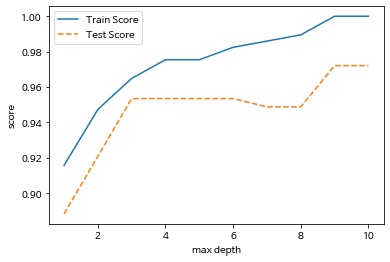

In [99]:
# 모델 설명력 그래프 확인
plt.plot(para_depth,train_score,linestyle='-',label='Train Score')
plt.plot(para_depth,test_score,linestyle='--',label='Test Score')
plt.ylabel('score')
plt.xlabel('max depth')
plt.legend()

#### max_depth가 증가함에 따라 train accuracy와 test accuracy가 증가하는데 Test/train 성능변화를 고려하여 9를 선택한다. 
#### max_depth=9

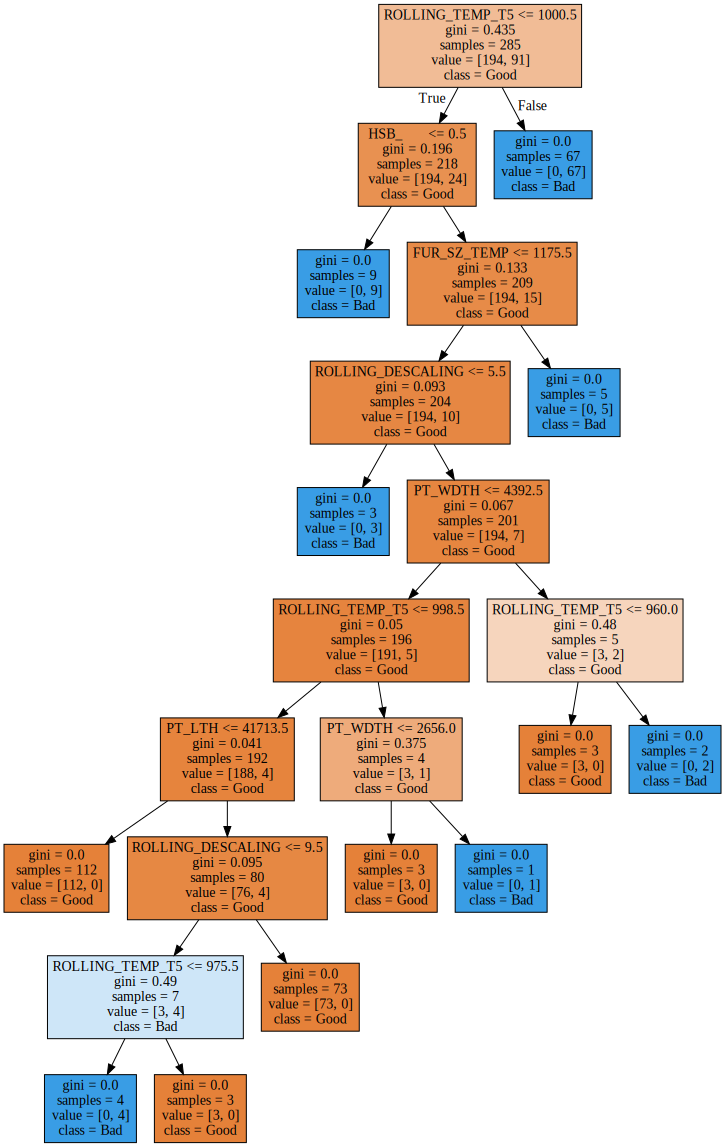

In [100]:
# 변수명 저장 
v_feature_name=df_train_x.columns

# 깊이가 4인 모델 
tree_low=DecisionTreeClassifier(max_depth=9, random_state=1234)
tree_low.fit(df_train_x,df_train_y)

# 트리 모델을 tree_low.dot 파일로 저장 (목표변수 0: Good, 1:Bad) 
export_graphviz(tree_low, out_file="tree_low.dot", class_names=["Good", "Bad"],\
               feature_names=v_feature_name, impurity=True, filled=True)

# graphviz를 이용해 트리 모델 시각화
with open("tree_low.dot") as f: 
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

#### min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능 

In [101]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# min_smaples_split: 분할하기 위한 노드의 최소 샘플수 
para_split=[n_split * 10 for n_split in range(1,11)] # 참조 : para_leaf:[10,20,30,...,100]

for v_min_samples_split in para_split:
    tree=DecisionTreeClassifier(random_state=1234,min_samples_split=v_min_samples_split,\
                                max_depth=9)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_split=pd.DataFrame()
df_accuracy_split['MinSamplesLeaf']=para_split
df_accuracy_split['TrainAccuracy']=train_accuracy
df_accuracy_split['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_split.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.979,0.949
1,20,0.979,0.949
2,30,0.979,0.949
3,40,0.979,0.949
4,50,0.979,0.949
5,60,0.979,0.949
6,70,0.979,0.949
7,80,0.979,0.949
8,90,0.975,0.953
9,100,0.975,0.953


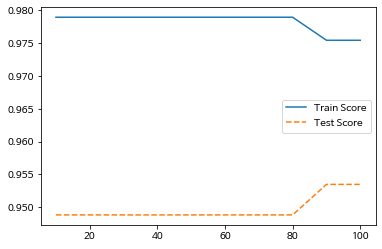

In [102]:
# 모델 설명력 그래프 확인
plt.plot(para_split,train_accuracy,linestyle='-',label='Train Score')
plt.plot(para_split,test_accuracy,linestyle='--',label='Test Score')
plt.legend()

#### 분리 노드의 최소 자료 수 증가에 따라 모델의 정확도는 감소하며, train/test 데이터의 성능 변화를 고려하였을 때, para_split 변수는 고려하지 않기로 한다. 

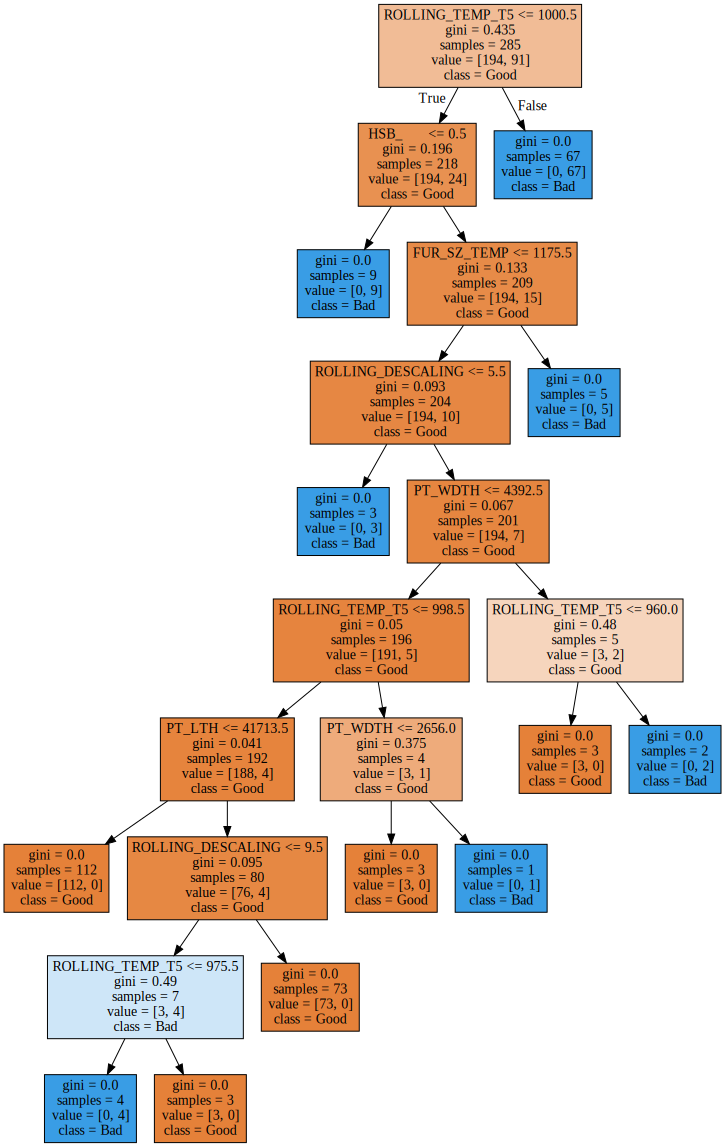

In [103]:
tree_low=DecisionTreeClassifier(random_state=1234,max_depth=9)
tree_low.fit(df_train_x,df_train_y)

export_graphviz(tree_low,out_file='tree_low.dot',class_names=["Good","Bad"],\
               feature_names=v_feature_name,impurity=True,filled=True)

with open('tree_low.dot') as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))# 분리 노드의 최소 사료 수가 30인 무델 

#### 파라미터 조정 : 잎사귀 노드의 최소 자료 수 변경

In [104]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# min_smaples_split: 분할하기 위한 노드의 최소 샘플수 
para_leaf=[n_leaf * 2 for n_leaf in range(1,11)] # 참조 : para_leaf:[2,4,6,...20]

for v_min_samples_leaf in para_leaf:
    tree=DecisionTreeClassifier(random_state=1234,min_samples_leaf=v_min_samples_leaf,max_depth=9)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_leaf=pd.DataFrame()
df_accuracy_leaf['MinSamplesLeaf']=para_leaf
df_accuracy_leaf['TrainAccuracy']=train_accuracy
df_accuracy_leaf['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,2,0.996,0.972
1,4,0.975,0.953
2,6,0.968,0.949
3,8,0.954,0.912
4,10,0.916,0.888
5,12,0.916,0.888
6,14,0.916,0.888
7,16,0.916,0.888
8,18,0.916,0.888
9,20,0.916,0.888


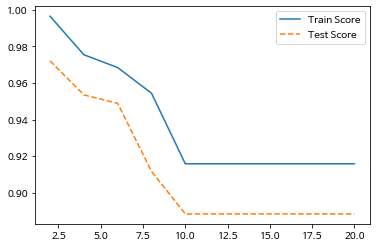

In [105]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf,train_accuracy,linestyle='-',label='Train Score')
plt.plot(para_leaf,test_accuracy,linestyle='--',label='Test Score')
plt.legend()

In [106]:
# train 밒 test 정확도 결과 저장용 
train_accuracy=[]; test_accuracy=[]

# min_smaples_split: 분할하기 위한 노드의 최소 샘플수 
para_leaf=[n_leaf for n_leaf in range(1,11)] # 참조 : para_leaf:[2,4,6,...20]

for v_min_samples_leaf in para_leaf:
    tree=DecisionTreeClassifier(random_state=1234,min_samples_leaf=v_min_samples_leaf,\
                            max_depth=9)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장 
df_accuracy_leaf=pd.DataFrame()
df_accuracy_leaf['MinSamplesLeaf']=para_leaf
df_accuracy_leaf['TrainAccuracy']=train_accuracy
df_accuracy_leaf['TestAccuracy']=test_accuracy

# 모델 정확도 확인 
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,1,1.000,0.972
1,2,0.996,0.972
2,3,0.989,0.972
3,4,0.975,0.953
4,5,0.975,0.953
5,6,0.968,0.949
6,7,0.965,0.940
7,8,0.954,0.912
8,9,0.951,0.907
9,10,0.916,0.888


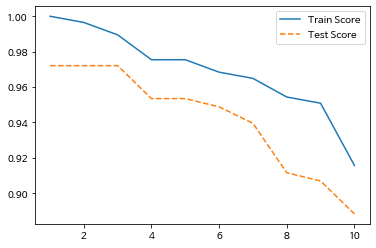

In [107]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf,train_accuracy,linestyle='-',label='Train Score')
plt.plot(para_leaf,test_accuracy,linestyle='--',label='Test Score')
plt.legend()

#### 잎사귀 노드 최소 자료 수가 2일 때 train의 정확도와 Test/train을 고려하였을 때, 가장 정확한 값을 보인다. 
#### min_samples_leaf=2

#### 최종 모델 

In [108]:
# 최종 모델 
tree_final=DecisionTreeClassifier(random_state=1234, max_depth=9, min_samples_leaf=2)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=2, random_state=1234)

#### 최종모델 시각화

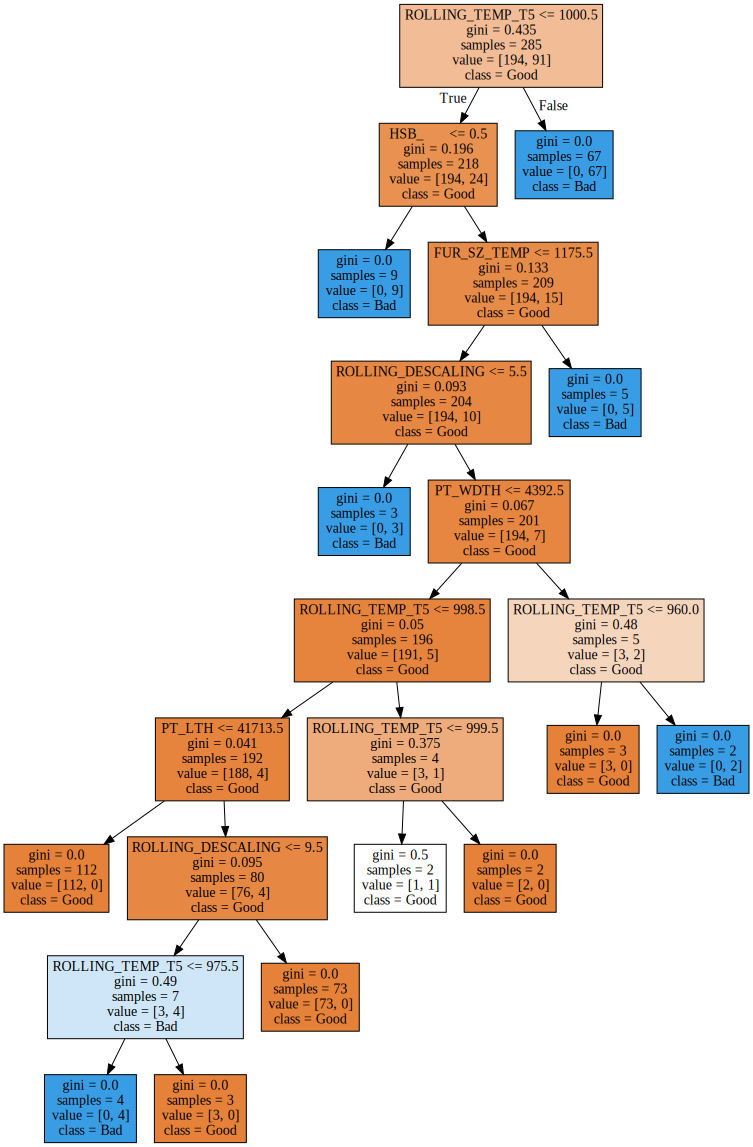

In [120]:
# tree_final.dot으로 결과 저장 
export_graphviz(tree_final, out_file="tree_final.dot", class_names=["Good","Bad"],\
               feature_names=v_feature_name, impurity=True, filled=True)

# tree_final.dot 그리기
with open("tree_final.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [124]:
import pydot
(graph,) = pydot.graph_from_dot_file("tree_final.dot",encoding='utf8')
graph.write_png('decisionTree.png')

In [110]:
# 평가 
y_pred=tree_final.predict(df_test_x)
print("Accuracy:{:.3f}".format(tree_final.score(df_train_x,df_train_y)))
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y,y_pred)))

Accuracy:0.996
Confusion matrix:
[[143   1]
 [  5  66]]


#### 모델의 정확도는 99.6%로 높은 값을 보인다. 
#### Confusion matrix를 고려하였을 때, 불량률은 7.04%로 다소 개선의 필요성이 보인다. 

#### 변수의 중요도 

In [111]:
# 변수명
v_feature_name=df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance_10=df_importance[0:10]
df_importance_10.round(3)

,Feature,Importance
6,ROLLING_TEMP_T5,0.715
21,HSB_적용,0.121
7,ROLLING_DESCALING,0.079
5,FUR_SZ_TEMP,0.072
1,PT_WDTH,0.011
2,PT_LTH,0.002
0,PT_THK,0.000
16,STEEL_KIND_T8,0.000
24,WORK_GR_3조,0.000
23,WORK_GR_2조,0.000


<ipython-input-112-500cd8894b48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importance_10.sort_values('Importance',ascending=True,inplace=True)


Text(0, 0.5, '변수')

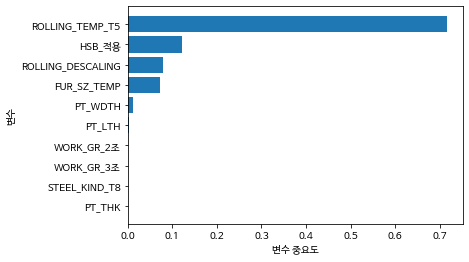

In [112]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance_10.sort_values('Importance',ascending=True,inplace=True)
coordinates=range(len(df_importance_10))
plt.barh(y=coordinates,width=df_importance_10['Importance'])
plt.yticks(coordinates,df_importance_10['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')